In [ ]:
ABSOLUTE READ COUNTS

In [2]:
import glob
import pandas as pd

# Find all baked_phage CSVs
files = glob.glob("input_oligos*.csv")
if not files:
    raise FileNotFoundError("No baked_phage*.csv files found in this directory.")

# Initialize an empty DataFrame
combined = pd.DataFrame()

# Read each file and merge
for f in files:
    df = pd.read_csv(f, header=None, names=["peptide", "count"])
    if combined.empty:
        combined = df
    else:
        # merge on peptide name, fill missing counts with 0
        combined = pd.merge(combined, df, on="peptide", how="outer", suffixes=("", "_tmp")).fillna(0)
        # sum across duplicate columns
        count_cols = [col for col in combined.columns if col.startswith("count")]
        combined["count"] = combined[count_cols].sum(axis=1)
        # drop extra columns
        combined = combined[["peptide", "count"]]

# Save summed results
combined.to_csv("summed_input_oligos_peptide_counts.csv", index=False)

print("Saved summed counts to summed_peptide_counts.csv")


Saved summed counts to summed_peptide_counts.csv


In [14]:
import pandas as pd

df = pd.read_csv("summed_peptide_counts_baked_phage.csv")

# total library size
library_size = 90128  

# peptides detected (≥1 read)
detected = (df["count"] > 0).sum()

# representation fraction
fraction = detected / library_size

print(f"Detected peptides: {detected:,} / {library_size:,}")
print(f"Representation: {fraction:.2%}")


Detected peptides: 89,869 / 90,128
Representation: 99.71%


5th percentile: 32.00
95th percentile: 83.00


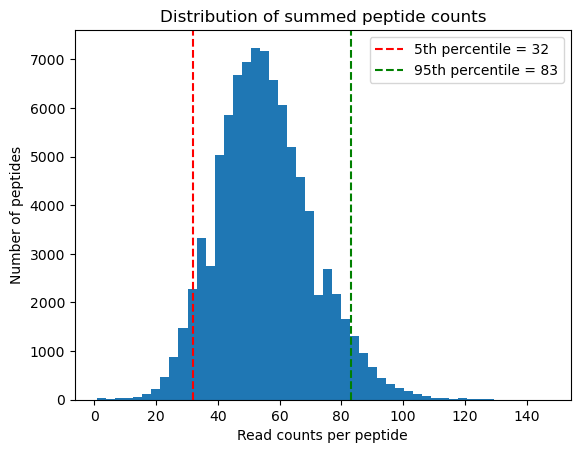

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("summed_input_oligos_peptide_counts.csv")
counts = df["count"]

# Compute 5th and 95th percentiles
p5 = np.percentile(counts, 5)
p95 = np.percentile(counts, 95)

print(f"5th percentile: {p5:.2f}")
print(f"95th percentile: {p95:.2f}")

plt.hist(counts, bins=50)
plt.xlabel("Read counts per peptide")
plt.ylabel("Number of peptides")
plt.title("Distribution of summed peptide counts")
# Add percentile lines
plt.axvline(p5, color="red", linestyle="--", label=f"5th percentile = {p5:.0f}")
plt.axvline(p95, color="green", linestyle="--", label=f"95th percentile = {p95:.0f}")

plt.legend()
plt.savefig("summed_counts_histogram_with_percentiles.png", dpi=300)
plt.show()



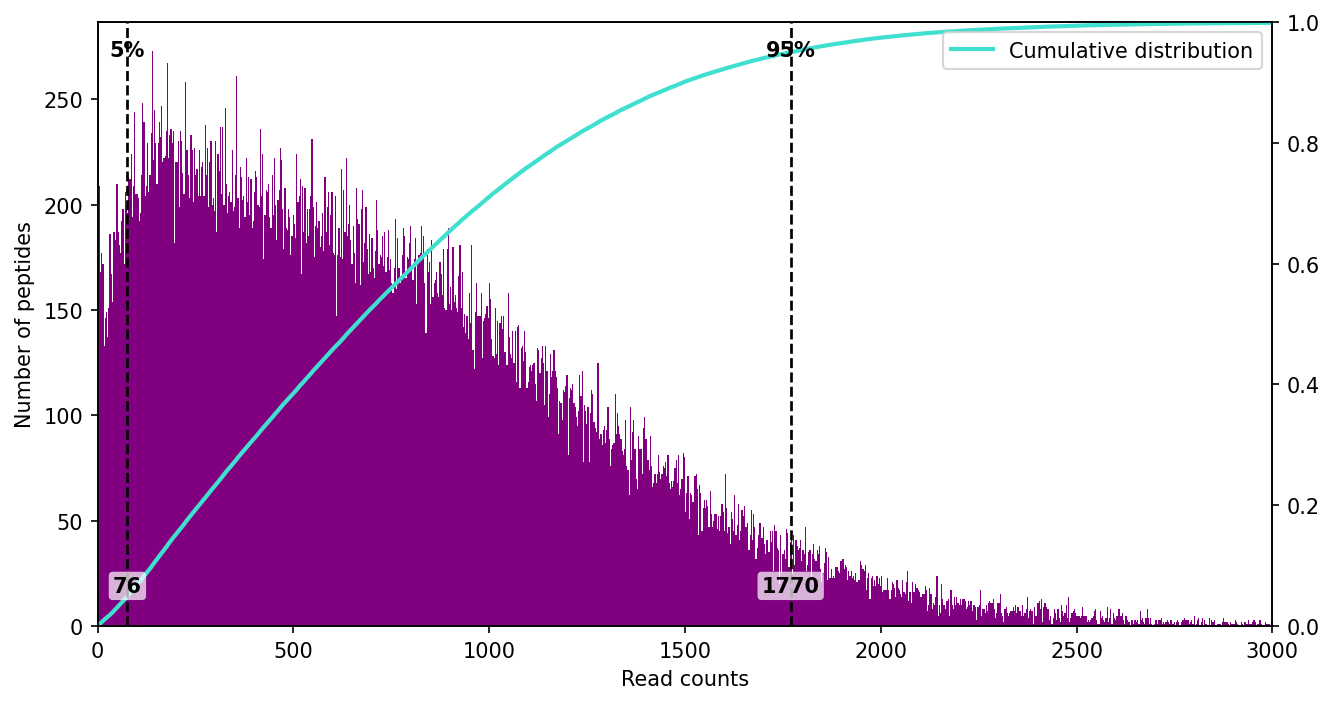

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- load your counts ---
# If you already have a Series called `counts`, skip the next two lines.
df = pd.read_csv("summed_peptide_counts_baked_phage.csv")  # change to your file
counts = df["count"].to_numpy()                            # change column name if needed

# --- percentiles ---
p5  = np.percentile(counts, 5)
p95 = np.percentile(counts, 95)

# --- histogram bins (tweak binwidth if you want smoother/rougher bars) ---
binwidth = 3
bins = np.arange(0, counts.max() + binwidth, binwidth)

hist, edges = np.histogram(counts, bins=bins)
centers = 0.5 * (edges[:-1] + edges[1:])
widths  = np.diff(edges)

# --- cumulative distribution (empirical CDF from the histogram) ---
cdf = np.cumsum(hist) / hist.sum()

# --- plot ---
fig, ax = plt.subplots(figsize=(9,4.8), dpi=150)
ax2 = ax.twinx() #second axis for cdf

# Put primary axis above the twin and make its face transparent
ax.set_zorder(1)
ax2.set_zorder(2)
ax2.patch.set_visible(False)  # so bars remain visible

# histogram (black bars)
ax.bar(centers, hist, width=widths, align="center", color="purple", zorder=2)
ax.set_xlabel("Read counts")
ax.set_ylabel("Number of peptides")

#read CDF 
ax2.plot(edges[1:], cdf, lw=2, color="turquoise", label="Cumulative distribution", zorder=1)
ax2.set_ylim(0, 1)
ax2.set_ylabel("")  # optional
ax2.legend(loc="upper right")

# Percentiles (front, on ax2; use ax2 limits!)
def annotate_percentile_on_ax2(x, label):
    ax2.axvline(x, color="black", ls="--", lw=1.3, zorder=3)
    ymin2, ymax2 = ax2.get_ylim()
    # top label
    ax2.text(x, ymax2*0.97, label, color="black", fontweight="bold",
             ha="center", va="top", zorder=4,
             bbox=dict(boxstyle="round,pad=0.2", fc="none", ec="none", alpha=0.7))
    # numeric value near bottom
    ax2.text(x, ymin2 + (ymax2 - ymin2)*0.05, f"{int(round(x))}",
             color="black", ha="center", fontweight="bold", va="bottom", zorder=4,
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))

annotate_percentile_on_ax2(p5,  "5%")
annotate_percentile_on_ax2(p95, "95%")

plt.tight_layout()
plt.xlim(0, 3000)
plt.show()

147.0
6300.0


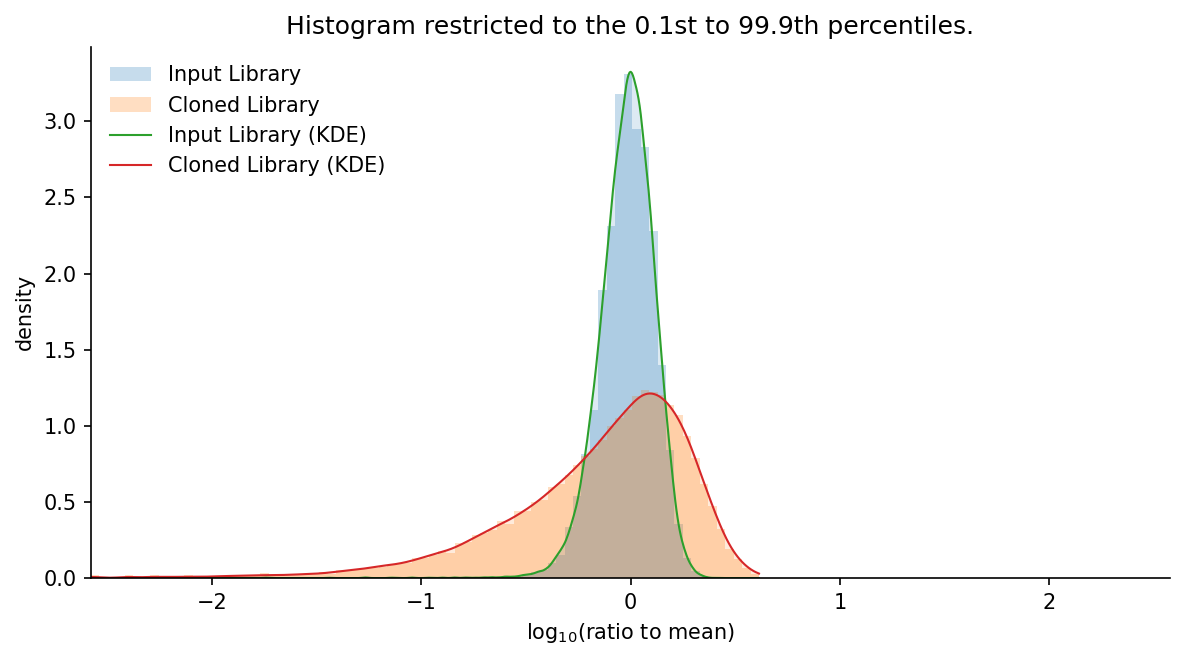

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Load your two count vectors ----
# Replace these with your files/columns
df_in  = pd.read_csv("summed_input_oligos_peptide_counts.csv")
df_cl  = pd.read_csv("summed_peptide_counts_baked_phage.csv")
print(df_in['count'].max())
print(df_cl['count'].max())

counts_input  = df_in["count"].to_numpy()
counts_cloned = df_cl["count"].to_numpy()

# ---- Transform to log10(ratio to mean) ----
"""
This normalizes each peptide's representation relative to the library mean (so mean of all peptide counts), 
and it logs it so you can see over and underrepresented peptides on a symmetric scale. 

log10(count (i) / mean count)"""
def log_ratio_to_mean(x):
    x = np.asarray(x, dtype=float)
    m = np.mean(x)
    # add a tiny epsilon so zeros don’t blow up the log
    return np.log10((x + 1e-9) / (m + 1e-9))

x_in  = log_ratio_to_mean(counts_input)
x_cl  = log_ratio_to_mean(counts_cloned)

# ---- Simple Gaussian KDE (no SciPy dependency) ----
"""
A KDE is just a smooth approximate representation of a histogram. So instead of these bars (bins) you get a curve. 
Here the script implements a gaussian KDE from scratch 
"""
def kde_1d(x, grid, bandwidth=None):
    x = x.ravel()
    if bandwidth is None:
        # Silverman’s rule-of-thumb
        std = np.std(x, ddof=1)
        n   = len(x)
        bandwidth = 1.06 * std * n ** (-1/5)
        if bandwidth <= 0:
            bandwidth = 0.1
    # compute kernel density
    # (grid[:,None] - x[None,:])^2 -> distances, Gaussian kernel
    d2 = (grid[:, None] - x[None, :])**2
    k  = np.exp(-0.5 * d2 / (bandwidth**2)) / (np.sqrt(2*np.pi) * bandwidth)
    # average over samples to get density; normalize to integrate ~1
    dens = k.mean(axis=1)
    # numerical normalization to make it a proper density
    dx = np.diff(grid).mean()
    dens = dens / (np.sum(dens) * dx)
    return dens

# ---- Common grid for plotting ----
xmin = min(np.percentile(x_in,  0.1), np.percentile(x_cl,  0.1))
xmax = max(np.percentile(x_in, 99.9), np.percentile(x_cl, 99.9))
grid = np.linspace(xmin, xmax, 600)

dens_in = kde_1d(x_in, grid)
dens_cl = kde_1d(x_cl, grid)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)

# Overlaid histograms as densities (transparent)
bins = np.linspace(xmin, xmax, 80)
ax.hist(x_in, bins=bins, density=True, alpha=0.25, label="Input Library")
ax.hist(x_cl, bins=bins, density=True, alpha=0.25, label="Cloned Library")

# Smooth KDE curves + light fills
ax.plot(grid, dens_in, linewidth=1, label="Input Library (KDE)")
ax.fill_between(grid, dens_in, alpha=0.15)
ax.plot(grid, dens_cl, linewidth=1, label="Cloned Library (KDE)")
ax.fill_between(grid, dens_cl, alpha=0.15)

#pick symmetric limits 
x_absmax = max(abs(xmin), abs(xmax), 2)
ax.set_xlim(-x_absmax, x_absmax)
ax.set_xticks(np.arange(-int(x_absmax), int(x_absmax)+1, 1))

# Cosmetics

#grid is the x-axis sampling points where you evaluate the KDE 
ax.set_title("Histogram restricted to the 0.1st to 99.9th percentiles.")
ax.set_xlabel("log$_{10}$(ratio to mean)")
ax.set_ylabel("density")
ax.legend(loc="upper left", frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()


Input  coverage: 90,111/90,132 = 99.98% (missing 21)
Cloned coverage: 89,869/90,132 = 99.71% (missing 263)


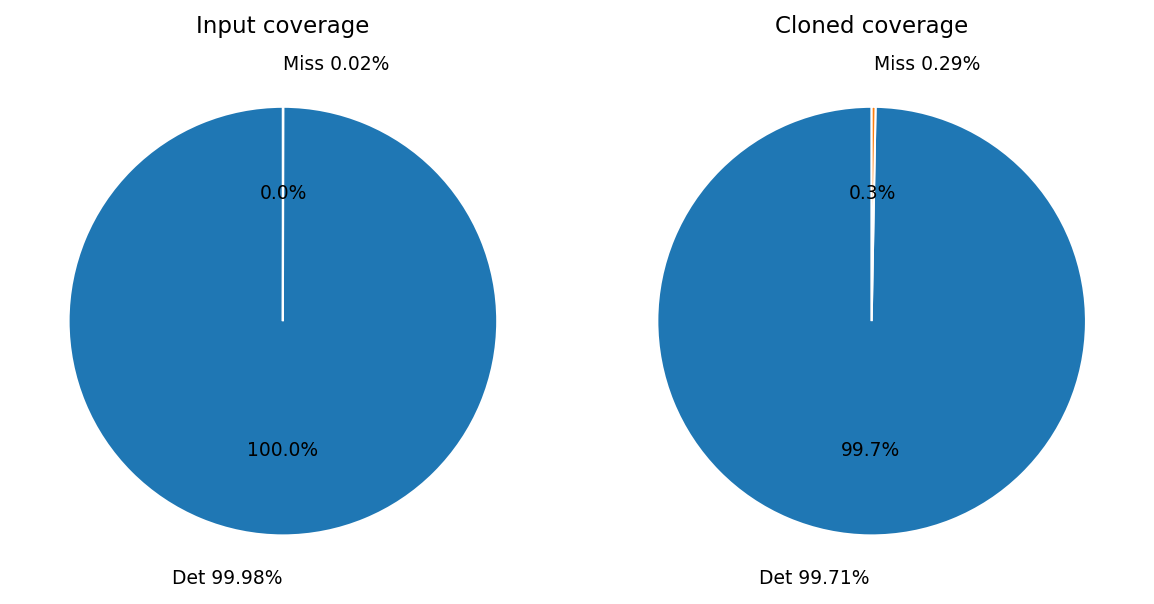

In [67]:
import matplotlib.pyplot as plt


TOTAL_DESIGNED = 90132
det_in = int((counts_input  > 0).sum())
det_cl = int((counts_cloned > 0).sum())
mis_in = max(TOTAL_DESIGNED - det_in, 0)
mis_cl = max(TOTAL_DESIGNED - det_cl, 0)

counts_input  = df_in["count"].to_numpy()
counts_cloned = df_cl["count"].to_numpy()

cov_in = det_in / TOTAL_DESIGNED * 100.0
cov_cl = det_cl / TOTAL_DESIGNED * 100.0

print(f"Input  coverage: {det_in:,}/{TOTAL_DESIGNED:,} = {cov_in:.2f}% (missing {mis_in:,})")
print(f"Cloned coverage: {det_cl:,}/{TOTAL_DESIGNED:,} = {cov_cl:.2f}% (missing {mis_cl:,})")

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150)

# Input coverage pie
axes[0].pie([det_in, mis_in],
            labels=[f"Det {cov_in:.2f}%", f"Miss {100-cov_in:.2f}%"],
            startangle=90, autopct="%1.1f%%",
            wedgeprops=dict(edgecolor="white"),
            textprops=dict(fontsize=9),
            labeldistance=1.2)
axes[0].set_title("Input coverage", fontsize=11, pad=10)

# Cloned coverage pie
axes[1].pie([det_cl, mis_cl],
            labels=[f"Det {cov_cl:.2f}%", f"Miss {100-cov_cl:.2f}%"],
            startangle=90, autopct="%1.1f%%",
            wedgeprops=dict(edgecolor="white"),
            textprops=dict(fontsize=9),
            labeldistance=1.2)
axes[1].set_title("Cloned coverage", fontsize=11, pad=10)

plt.tight_layout()
plt.show()


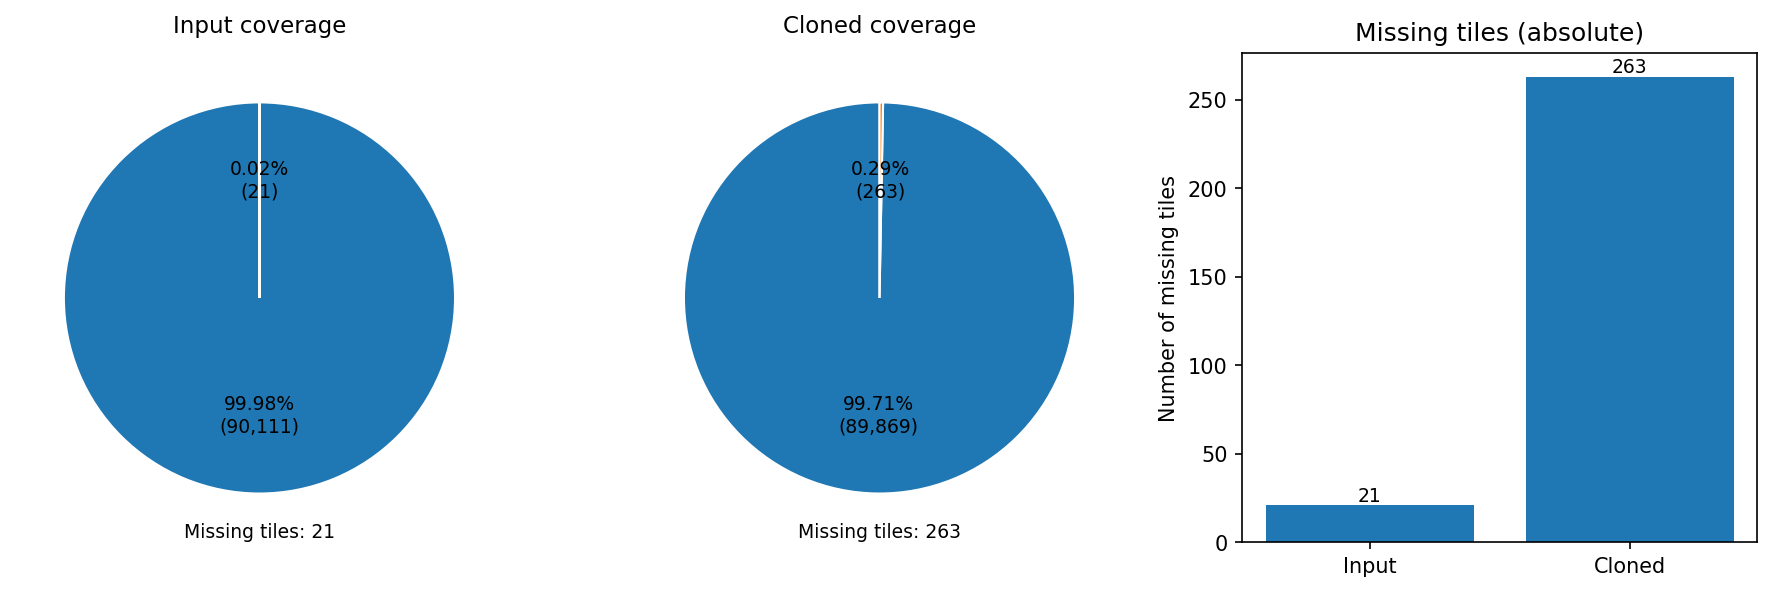

In [74]:
import matplotlib.ticker as mtick

# ----- Plot: two pies + a bar for missing tiles -----
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=150)

# Reusable autopct that shows both % and absolute count
def autopct_counts(values):
    total = sum(values)
    def _fmt(pct):
        count = int(round(pct/100.0 * total))
        return f"{pct:.2f}%\n({count:,})"
    return _fmt

# Input coverage pie
axes[0].pie(
    [det_in, mis_in],
    startangle=90,
    autopct=autopct_counts([det_in, mis_in]),
    wedgeprops=dict(edgecolor="white"),
    textprops=dict(fontsize=9),
    labeldistance=1.15
)
axes[0].set_title("Input coverage", fontsize=11, pad=10)
axes[0].text(0.0, -1.2, f"Missing tiles: {mis_in:,}", ha="center", va="center", fontsize=9)

# Cloned coverage pie
axes[1].pie(
    [det_cl, mis_cl],
    startangle=90,
    autopct=autopct_counts([det_cl, mis_cl]),
    wedgeprops=dict(edgecolor="white"),
    textprops=dict(fontsize=9),
    labeldistance=1.15
)
axes[1].set_title("Cloned coverage", fontsize=11, pad=10)
axes[1].text(0.0, -1.2, f"Missing tiles: {mis_cl:,}", ha="center", va="center", fontsize=9)

# Bar chart for missing tiles
labels = ["Input", "Cloned"]
missing_vals = [mis_in, mis_cl]
bars = axes[2].bar(labels, missing_vals)
axes[2].set_ylabel("Number of missing tiles")
axes[2].set_title("Missing tiles (absolute)")

# Add value labels on bars
for b, v in zip(bars, missing_vals):
    axes[2].text(b.get_x() + b.get_width()/2, v, f"{v:,}", ha="center", va="bottom", fontsize=9)

# Optional: nicer y-axis formatting with thousands separators
axes[2].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{int(x):,}"))

plt.tight_layout()
plt.show()


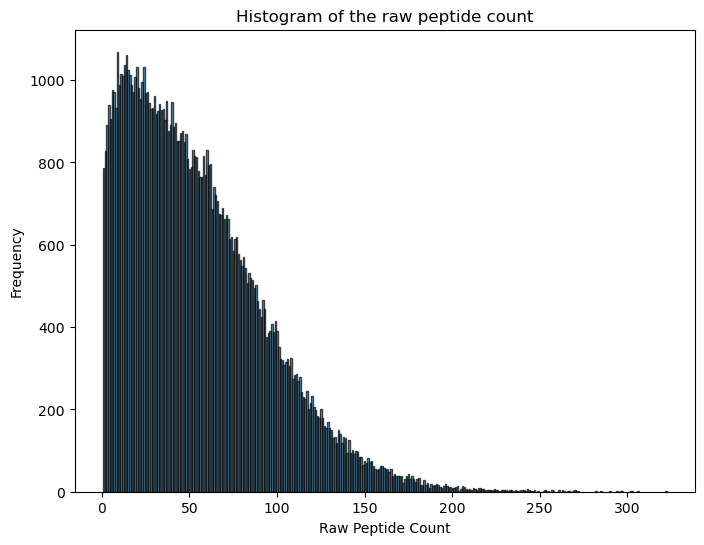

In [ ]:
#convert the raw peptide count stats you get form phagedb to a histogram 

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv("baked_phage_F4_S4_R1_001.csv")

col = pd.to_numeric(df.iloc[:, 1], errors="coerce").dropna().astype(int)

freq = col.value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(freq.index, freq.values, edgecolor="black", alpha=0.7)
plt.xlabel("Raw Peptide Count")
plt.ylabel("Frequency")
plt.title("Histogram of the raw peptide count")
plt.show()